In [1]:
import argparse
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow.lite as tflite
from tensorflow import keras
import zlib
from platform import python_version
import tensorflow_model_optimization as tfmot   
import tempfile
print(f"Python version used to excute the code is {python_version()}")



Python version used to excute the code is 3.7.5


In [2]:
from classes import read_audios
from classes import SignalGenerator
from classes import make_models
from classes import model_analysis

In [3]:
version = "a"
m = "cnn"   # model name [ mlp , cnn , ds_cnn  ]
mfcc = True    # True --> excute mfcc , False --> excute STFT
alpha = 0.3    # The width multiplier used to apply the structured Pruning 

model_version = f"_V_{version}_alpha={alpha}"
mymodel = m + model_version
TFLITE =  f'{mymodel}.tflite'     # path for saving the best model after converted to TF.lite model 
units = 8                         # The number of output class [8:without silence , 9 : with silence]
################## Fix the Random seed to reproduce the same results 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
reading_class = read_audios('E:\Github\Machine-learning-for-IOT\Lab3\ex2\data\mini_speech_commands')
train_files, val_files, test_files = reading_class.read()

In [5]:
LABELS = np.array(['stop', 'up', 'yes', 'right', 'left', 'no',  'down', 'go'] , dtype = str) 

STFT_OPTIONS = {'frame_length': 256, 'frame_step': 128, 'mfcc': False}
MFCC_OPTIONS = {'frame_length': 640, 'frame_step': 320, 'mfcc': True,
        'lower_frequency': 20, 'upper_frequency': 4000, 'num_mel_bins': 40,
        'num_coefficients': 10}
if mfcc is True:
    options = MFCC_OPTIONS
    strides = [2, 1]
else:
    options = STFT_OPTIONS
    strides = [2, 2]

generator = SignalGenerator(LABELS, 16000, **options)
train_ds = generator.make_dataset(train_files, True)
val_ds = generator.make_dataset(val_files, False)
test_ds = generator.make_dataset(test_files, False)

In [6]:
model_maker = make_models()
model, model_checkpoint_callback, checkpoint_filepath = model_maker.models(alpha, strides, units, model_version, mfcc, mymodel)


200/200 [==============================] - ETA: 0s - loss: 1.7068 - sparse_categorical_accuracy: 0.4658
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.70125, saving model to ./checkpoints/mfcc\chkp_best_cnn_V_a_alpha=0.3
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./checkpoints/mfcc\chkp_best_cnn_V_a_alpha=0.3\assets
200/200 [==============================] - 14s 69ms/step - loss: 1.7068 - sparse_categorical_accuracy: 0.4658 - val_loss: 1.2854 - val_sparse_categorical_accuracy: 0.7013


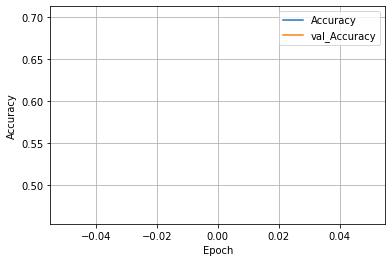

In [7]:
history = model.fit(train_ds, epochs=1,   validation_data=val_ds,callbacks=[model_checkpoint_callback ])
model_maker.plot_loss(history, mymodel)

In [8]:
analysis = model_analysis(test_ds, checkpoint_filepath, train_ds)
Compressed , tflite_model_dir = analysis.S_pruning_Model_evaluate_and_compress_to_TFlite( tflite_model_dir = TFLITE)

25/25 [==============================] - 2s 75ms/step - loss: 1.2899 - sparse_categorical_accuracy: 0.6950
************************************************** 
  The accuracy achieved by the best model before convertion = 69.50% 
************************************************** 
 the model is saved successfuly to ./models/cnn_V_a_alpha=0.3.tflite


In [9]:
analysis.load_and_evaluation(tflite_model_dir, Compressed)

************************************************** 
 The Size of TF lite model  Before compression is = 110.712 kb
************************************************** 
 The Size of TF lite model  After compression is = 100.92 kb
************************************************** 
 The accuracy of TF lite model is = 69.50 


In [11]:
Compressed , Quantized   = analysis.apply_Quantization(TFLITE, PQT=True , WAPQT = False)

the model is saved successfuly to ./models/PQT_cnn_V_a_alpha=0.3.tflite


In [12]:
analysis.load_and_evaluation(Quantized , Compressed)

************************************************** 
 The Size of TF lite model  Before compression is = 32.992 kb
************************************************** 
 The Size of TF lite model  After compression is = 28.237 kb
************************************************** 
 The accuracy of TF lite model is = 69.62 


In [15]:
WA_Compressed , WA_Quantized   = analysis.apply_Quantization(TFLITE, PQT=False ,WAPQT=True)

TypeError: 'generator' object is not callable

In [ ]:
analysis.load_and_evaluation(WA_Quantized , WA_Compressed)